# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install s3fs

  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.10.0-py3-none-any.whl (179 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
ERROR: Cannot uninstall fsspec 2023.6.0, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps fsspec==2023.6.0'.


In [1]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [9]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2024-11-03 22:58:17--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.216.16, 52.219.220.64, 52.219.117.128, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.216.16|:443... connected.
ERROR: cannot verify s3-us-west-1.amazonaws.com's certificate, issued by ‘CN=Amazon RSA 2048 M01,O=Amazon,C=US’:
  Unable to locally verify the issuer's authority.
To connect to s3-us-west-1.amazonaws.com insecurely, use `--no-check-certificate'.
Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [2]:
BUCKET = 'legc-deep-learning'
role = sagemaker.get_execution_role()
session = sagemaker.Session()
s3_client = boto3.client('s3')

In [11]:
# sync up data with my bucket
!aws s3 sync ./dogImages/train s3://{BUCKET}/train
!aws s3 sync ./dogImages/test s3://{BUCKET}/test
!aws s3 sync ./dogImages/valid s3://{BUCKET}/valid

upload: dogImages/train/049.Chinese_crested/Chinese_crested_03503.jpg to s3://legc-deep-learning/train/049.Chinese_crested/Chinese_crested_03503.jpg
upload: dogImages/train/049.Chinese_crested/Chinese_crested_03502.jpg to s3://legc-deep-learning/train/049.Chinese_crested/Chinese_crested_03502.jpg
upload: dogImages/train/049.Chinese_crested/Chinese_crested_03496.jpg to s3://legc-deep-learning/train/049.Chinese_crested/Chinese_crested_03496.jpg
upload: dogImages/train/049.Chinese_crested/Chinese_crested_03506.jpg to s3://legc-deep-learning/train/049.Chinese_crested/Chinese_crested_03506.jpg
upload: dogImages/train/049.Chinese_crested/Chinese_crested_03500.jpg to s3://legc-deep-learning/train/049.Chinese_crested/Chinese_crested_03500.jpg
upload: dogImages/train/049.Chinese_crested/Chinese_crested_03495.jpg to s3://legc-deep-learning/train/049.Chinese_crested/Chinese_crested_03495.jpg
upload: dogImages/train/049.Chinese_crested/Chinese_crested_03505.jpg to s3://legc-deep-learning/train/049

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [3]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import HyperparameterTuner, CategoricalParameter

# Defining hypeparamters...
hyperparameter_ranges = {
    # 'learning_rate': CategoricalParameter([0.001, 0.00125, 0.00150]), # 25% increment
    'learning_rate': CategoricalParameter([0.00075 ,0.001]), # Best result has always being 0.001, downgrade 25%
    # 'epochs': CategoricalParameter([1, 5, 10]),
    # 'epochs': CategoricalParameter([1, 2, 3]),
    'epochs': CategoricalParameter([3, 5]),
    # 'optimizer': CategoricalParameter(['adam', 'sgd']),
    # 'optimizer': 'sgd', # Fixed, always better results than adam, directly passed to the estimator
    # 'train_batch_size': CategoricalParameter([25, 50, 100])
    'train_batch_size': CategoricalParameter([50, 100])
}

# Metric definitions
metric_definitions = [
    {
        'Name': 'Test Loss', 
        'Regex': 'Test Loss: ([0-9\\.]+)'
    },
    {
        'Name': 'Test Accuracy', 
        'Regex': 'Test Accuracy: ([0-9\\.]+)%'
        }
]


In [4]:
#TODO: Create estimators for your HPs

# Define the Pytorch estimator for training 
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="hpo_tunning_dogs_category",
    role=role,
    py_version="py3",
    framework_version='1.4.0',
    instance_count=1,
    # instance_type='ml.m5.xlarge',
    hyperparameters={
        'optimizer': 'adam',  # Fixed to 'adam'
    },
    instance_type='ml.m5.4xlarge',
    dependencies=['requirements.txt']
)
 
# let's do it
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name='Test Loss',
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=8,
    max_parallel_jobs=4
)



In [7]:
# TODO: Fit your HP Tuner
import time

start = time.time()
tuner.fit({'train': f"s3://{BUCKET}/train"}, wait=True)
end = time.time()

print(f"Total time taken for hyperparameter tuning: {end - start} seconds")

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..............................................................................................................................................

Best hyperparameters found:
epochs                     "3"
learning_rate          "0.001"
train_batch_size          "50"
FinalObjectiveValue     3.8651
Name: 5, dtype: object
  epochs learning_rate train_batch_size  \
0    "1"       "0.001"            "100"   
1    "1"       "0.001"             "50"   
2    "1"     "0.00075"             "50"   
3    "3"     "0.00075"             "50"   
4    "3"       "0.001"            "100"   

                             TrainingJobName TrainingJobStatus  \
0  pytorch-training-241111-1512-008-86ccd30a         Completed   
1  pytorch-training-241111-1512-007-3af3e4a7         Completed   
2  pytorch-training-241111-1512-006-dd27286d         Completed   
3  pytorch-training-241111-1512-005-de97dab4         Completed   
4  pytorch-training-241111-1512-004-0363463c         Completed   

   FinalObjectiveValue         TrainingStartTime           TrainingEndTime  \
0               5.0438 2024-11-11 15:40:45+00:00 2024-11-11 15:50:00+00:00   
1            

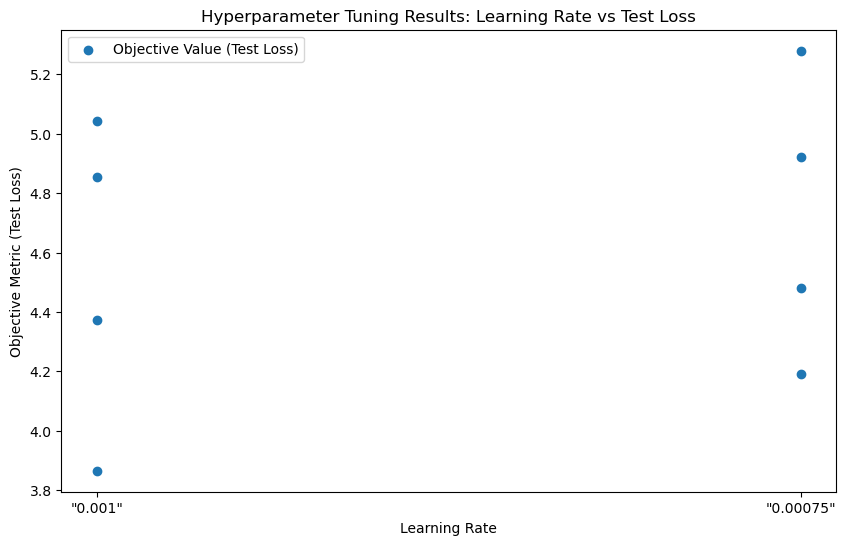

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the tuning job name correctly
tuning_job_name = tuner.latest_tuning_job.name  # Get the actual job name as a string

# Use the tuning job name to fetch analytics data
from sagemaker.analytics import HyperparameterTuningJobAnalytics
tuning_job_analytics = HyperparameterTuningJobAnalytics(tuning_job_name)
df = tuning_job_analytics.dataframe()

# Find the best configuration based on the lowest FinalObjectiveValue (Test Loss)
best_row = df.loc[df['FinalObjectiveValue'].idxmin()]
print("Best hyperparameters found:")
print(best_row[['epochs', 'learning_rate', 'train_batch_size', 'FinalObjectiveValue']])

# Show the top rows to check the data
print(df.head())

# Plot the results - Learning Rate vs Final Objective Metric (Test Loss)
plt.figure(figsize=(10, 6))
plt.scatter(df["learning_rate"], df["FinalObjectiveValue"], label="Objective Value (Test Loss)")
plt.xlabel("Learning Rate")
plt.ylabel("Objective Metric (Test Loss)")
plt.title("Hyperparameter Tuning Results: Learning Rate vs Test Loss")
plt.legend()
plt.show()

In [ ]:
results_df = tuner.analytics().dataframe()
display(results_df)

,epochs,learning_rate,train_batch_size,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""1""","""0.001""","""100""",pytorch-training-241111-1512-008-86ccd30a,Completed,5.0438,2024-11-11 15:40:45+00:00,2024-11-11 15:50:00+00:00,555.0
1,"""1""","""0.001""","""50""",pytorch-training-241111-1512-007-3af3e4a7,Completed,4.8528,2024-11-11 15:40:43+00:00,2024-11-11 15:50:04+00:00,561.0
2,"""1""","""0.00075""","""50""",pytorch-training-241111-1512-006-dd27286d,Completed,4.9227,2024-11-11 15:40:42+00:00,2024-11-11 15:49:58+00:00,556.0
3,"""3""","""0.00075""","""50""",pytorch-training-241111-1512-005-de97dab4,Completed,4.1915,2024-11-11 15:25:39+00:00,2024-11-11 15:50:20+00:00,1481.0
4,"""3""","""0.001""","""100""",pytorch-training-241111-1512-004-0363463c,Completed,4.3725,2024-11-11 15:13:40+00:00,2024-11-11 15:39:31+00:00,1551.0
5,"""3""","""0.001""","""50""",pytorch-training-241111-1512-003-78e3de12,Completed,3.8651,2024-11-11 15:13:46+00:00,2024-11-11 15:39:16+00:00,1530.0
6,"""3""","""0.00075""","""100""",pytorch-training-241111-1512-002-d19015ef,Completed,4.4816,2024-11-11 15:13:43+00:00,2024-11-11 15:39:37+00:00,1554.0
7,"""1""","""0.00075""","""100""",pytorch-training-241111-1512-001-81b76811,Completed,5.2796,2024-11-11 15:13:42+00:00,2024-11-11 15:25:28+00:00,706.0


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [15]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,  # Set your preferred interval
    framework_profile_params=FrameworkProfile(num_steps=10)  # Profile every 10 steps
)

# Define hooks for debugger
debugger_hook_config = DebuggerHookConfig(
    hook_parameters={"save_interval": "500"}  # Set interval as needed
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [17]:
# TODO: Create and fit an estimator

from sagemaker.pytorch import PyTorch

# Instantiate your estimator with best hyperparameters
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="dogs-images-optimized-training",
    role=role,
    py_version="py3",
    framework_version="1.4.0",
    instance_count=1,
    instance_type='ml.m5.4xlarge',
    dependencies=['requirements.txt'],
    hyperparameters={
        "epochs": 5,  # from tuning
        "learning_rate": 0.001,  # from tuning
        "optimizer": "adam",  # from tuning
        "train_batch_size": 50,  # from tuning
    },
    rules=rules,
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config,
)

# Fit the estimator with training data
estimator.fit({"train": f"s3://{BUCKET}/train", "validation": f"s3://{BUCKET}/valid"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dogs-images-optimized-training-2024-11-16-03-05-21-870


2024-11-16 03:05:22 Starting - Starting the training job...
2024-11-16 03:05:52 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2024-11-16 03:06:12 Downloading - Downloading input data......
2024-11-16 03:07:13 Downloading - Downloading the training image..

[2024-11-13 05:33:25.027 default:3869 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-11-13 05:33:25.040 default:3869 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-072298625118/dogs-images-optimized-training-2024-11-13-04-32-27-320/debug-output
[2024-11-13 05:33:25.511 default:3869 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-11-13 05:33:26.528 default:3869 INFO trial.py:210] Loaded all steps
Available Tensors: ['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.3.bias', 'gradient/ResNet_fc.3.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer4.0.relu_input_0', 'layer4.0.relu_input_1', 

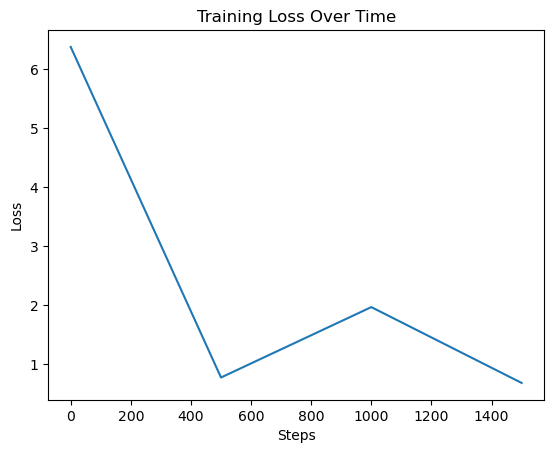

In [ ]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial

# Create a Debugger trial to access metrics
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print("Available Tensors:", trial.tensor_names())
print("Available steps:", trial.tensor("CrossEntropyLoss_output_0").steps())
print("Available values:", trial.tensor("CrossEntropyLoss_output_0").values())

# Plot loss or any other relevant metric
import matplotlib.pyplot as plt

# Extract the steps and corresponding loss values from the dictionary
steps = list(trial.tensor("CrossEntropyLoss_output_0").values().keys())
values = list(trial.tensor("CrossEntropyLoss_output_0").values().values())

# Plotting the data
import matplotlib.pyplot as plt

plt.plot(steps, values)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

yes I found `PoorWeightInitialization: IssuesFound`: Created initialize_weights to apply the initialization to the layers, particularly the Conv2d and Linear layers.

In [ ]:
# TODO: Display the profiler output
print(estimator.output_path)

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

import os
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

s3://sagemaker-us-east-1-072298625118/
2024-11-13 05:33:00     329706 dogs-images-optimized-training-2024-11-13-04-32-27-320/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-11-13 05:33:00     171069 dogs-images-optimized-training-2024-11-13-04-32-27-320/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-11-13 05:32:56        192 dogs-images-optimized-training-2024-11-13-04-32-27-320/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-11-13 05:32:56        200 dogs-images-optimized-training-2024-11-13-04-32-27-320/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-11-13 05:32:56        126 dogs-images-optimized-training-2024-11-13-04-32-27-320/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-11-13 05:32:56        127 dogs-images-optimized-training-2024-11-13-04-32-27-320/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
202

## Model Deploying

In [14]:
""" 
I had to check if the file actually exist, I had a bug, where I was not
saving the model in the default path so SageMaker was not able to push upload
the model to s3
"""

import boto3

s3_client = boto3.client('s3')
bucket_name = "sagemaker-us-east-1-072298625118"
job_name="dogs-images-optimized-training-2024-11-16-03-05-21-870"
key = f"{job_name}/output/model.tar.gz"

try:
    response = s3_client.head_object(Bucket=bucket_name, Key=key)
    print("Model file exists and is accessible:", response)
except s3_client.exceptions.ClientError as e:
    print("Error accessing model file:", e)

Model file exists and is accessible: {'ResponseMetadata': {'RequestId': 'V3RD0S933HNNPTRE', 'HostId': 'U0cJ0lKYqh6+bml7/htPjuHLWTKLbJhYrQnNVozLor79KzF5R24X0pX6ctcBhdOTEzSRT46s/SM=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'U0cJ0lKYqh6+bml7/htPjuHLWTKLbJhYrQnNVozLor79KzF5R24X0pX6ctcBhdOTEzSRT46s/SM=', 'x-amz-request-id': 'V3RD0S933HNNPTRE', 'date': 'Sat, 16 Nov 2024 04:46:13 GMT', 'last-modified': 'Sat, 16 Nov 2024 04:06:28 GMT', 'etag': '"860516d0c9e207e66108590b5d61fb9a-6"', 'x-amz-server-side-encryption': 'aws:kms', 'x-amz-server-side-encryption-aws-kms-key-id': 'arn:aws:kms:us-east-1:072298625118:key/a69f6faf-5016-48d2-9c25-5ac59a434efc', 'accept-ranges': 'bytes', 'content-type': 'binary/octet-stream', 'content-length': '42776918', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'AcceptRanges': 'bytes', 'LastModified': datetime.datetime(2024, 11, 16, 4, 6, 28, tzinfo=tzutc()), 'ContentLength': 42776918, 'ETag': '"860516d0c9e207e66108590b5d61fb9a-6"', 'ContentType': 'binary/

In [15]:
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.predictor import Predictor

jpeg_serializer = IdentitySerializer(content_type="image/jpeg")
json_deserializer = JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [16]:
from sagemaker.pytorch import PyTorch, PyTorchModel
import sagemaker

# Define role if not already defined
role = sagemaker.get_execution_role()

# Attach to the training job
estimator = PyTorch.attach(job_name)

# Use the model data from the training job
model_location = estimator.model_data

# Print model details
print("Model data location:", estimator.model_data)
print("Training job status:", estimator.latest_training_job.describe()['TrainingJobStatus'])

# Create the PyTorchModel for deployment

pytorch_model = PyTorchModel(
    model_data=model_location,
    role=role,
    entry_point='inference.py',
    py_version='py3',
    framework_version='1.4',
    predictor_cls=ImagePredictor,
    dependencies=["requirements.txt"]
)

# Deploy the model
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m5.4xlarge", wait=True)
print("Endpoint deployed:", predictor.endpoint_name)


2024-11-16 04:08:17 Starting - Preparing the instances for training
2024-11-16 04:08:17 Downloading - Downloading the training image
2024-11-16 04:08:17 Training - Training image download completed. Training in progress.
2024-11-16 04:08:17 Uploading - Uploading generated training model
2024-11-16 04:08:17 Completed - Training job completed
Model data location: s3://sagemaker-us-east-1-072298625118/dogs-images-optimized-training-2024-11-16-03-05-21-870/output/model.tar.gz
Training job status: Completed
------!Endpoint deployed: pytorch-inference-2024-11-16-04-46-54-782


In [17]:
image_path = "/home/sagemaker-user/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/dogImages/train/133.Yorkshire_terrier/Yorkshire_terrier_08314.jpg"

with open(image_path, "rb") as f:
    payload = f.read()
        
type(payload)

bytes

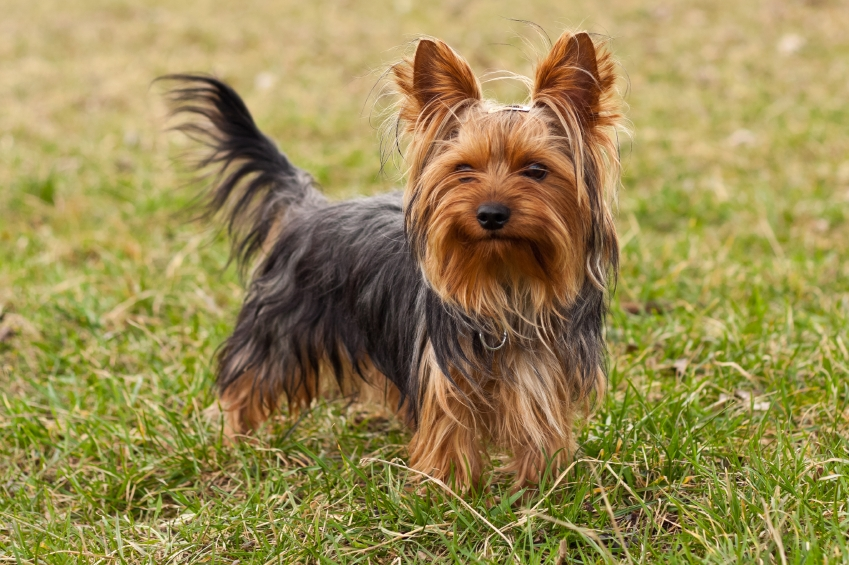

In [18]:
from PIL import Image
import io
Image.open(io.BytesIO(payload))


In [19]:
from sagemaker import Session

predictor = ImagePredictor(endpoint_name=predictor.endpoint_name, sagemaker_session=Session())

# Read the image as bytes
with open(image_path, "rb") as f:
    img_bytes = f.read()

# Send the image for prediction
response = predictor.predict(img_bytes)

print(response)

{'predicted_label': {'predicted_label': 132, 'class_name': 'Yorkshire_terrier'}}


In [20]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()